In [4]:
import numpy as np
from scipy import stats 
import pandas as pd
from tqdm.auto import tqdm
import cdpm
import pandas_datareader as pd_reader
from sklearn.preprocessing import add_dummy_feature
import matplotlib as mpl

/home/sangrey/anaconda3/envs/cdpm/lib/python3.7/site-packages/pandas_datareader/compat/__init__.py:7: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  from pandas.util.testing import assert_frame_equal


In [5]:
%matplotlib inline
mpl.style.use('seaborn-talk')
np.set_printoptions(precision=3, suppress=True)

In [6]:
num_draws = int(10000)
include_mean = True

In [7]:
filename = '../results/monthly_estimate_cdpm.tmp.hdf'
var_filename = '../results/monthly_estimate_var.tmp.hdf'

In [8]:
rel_cols = ['UNRATE', 'HSUPPLY', 'RCONSMP',  'OIL',
             'CONSSENTIMENT', 'EXCHANGERATE']
#rel_cols = ['UNRATE', 'HSUPPLY', 'INFLA', 'RCONSMP', 'M2', 'OIL']

In [9]:
cdpm.__version__

'0.12.02-py37_0'

## Import the data

In [10]:
data = pd_reader.data.DataReader('UNRATE', data_source='fred', start='1960', end='2019').apply(np.log).diff()
data.columns = ['UNRATE']
fred_cpi = pd_reader.data.DataReader('CPIAUCSL', data_source='fred', start='1960', end='2019').apply(np.log).diff()
fred_homesupply = pd_reader.data.DataReader('MSACSR', data_source='fred', start='1960', end='2019').apply(
    np.log).diff()
fred_rconsmp = pd_reader.data.DataReader('DPCERAM1M225NBEA', data_source='fred', start='1960', end='2019')
fred_prod = pd_reader.data.DataReader('INDPRO', data_source='fred', start='1960', end='2019').apply(
    np.log).diff()
fred_fedfunds = pd_reader.data.DataReader('FEDFUNDS', data_source='fred', start='1960', end='2019').diff()
fred_term_spread = pd_reader.data.DataReader('T10Y2YM', data_source='fred', start='1960', end='2019')
fred_m2 = pd_reader.data.DataReader('M2SL', data_source='fred', start='1960', end='2019').apply(np.log).diff()
fred_west_texas = pd_reader.data.DataReader('MCOILWTICO', data_source='fred', start='1960', end='2019').apply(
    np.log).diff()
fred_michigan_sentiment = pd_reader.data.DataReader('UMCSENT', data_source='fred', start='1960',
                                                    end='2019').apply(np.log)
fred_dollar_exchange_rate = pd_reader.data.DataReader('TWEXMMTH', data_source='fred', start='1960',
                                                      end='2019').apply(np.log)

data['INFLA'] = fred_cpi
data['HSUPPLY'] = fred_homesupply
data['RCONSMP'] = fred_rconsmp
data['FEDFUNDS'] = fred_fedfunds
data['TERMSPREAD'] = fred_term_spread
data['M2'] = fred_m2
data['OIL'] = fred_west_texas
data['CONSSENTIMENT'] =  fred_michigan_sentiment
data['EXCHANGERATE'] = fred_dollar_exchange_rate
data = data[rel_cols].dropna().transform(stats.zscore)

In [11]:
fred_term_spread.replace([np.inf, -np.inf], np.nan).min()

T10Y2YM   -2.13
dtype: float64

In [12]:
data.count()

UNRATE           396
HSUPPLY          396
RCONSMP          396
OIL              396
CONSSENTIMENT    396
EXCHANGERATE     396
dtype: int64

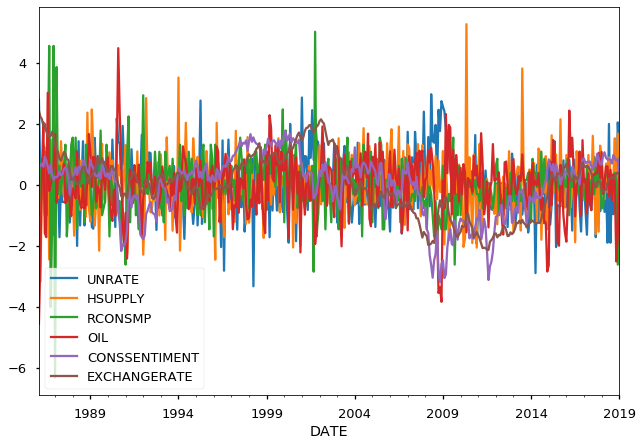

In [13]:
data[rel_cols].plot()

In [14]:
data.describe()

UNRATE       HSUPPLY       RCONSMP           OIL  CONSSENTIMENT  \
count  3.960000e+02  3.960000e+02  3.960000e+02  3.960000e+02   3.960000e+02   
mean  -2.130731e-17 -1.345725e-17  8.971499e-18 -1.570012e-17   3.588600e-16   
std    1.001265e+00  1.001265e+00  1.001265e+00  1.001265e+00   1.001265e+00   
min   -3.326996e+00 -3.178871e+00 -6.319128e+00 -4.550885e+00  -3.183841e+00   
25%   -6.736232e-01 -5.727594e-01 -5.346280e-01 -5.731304e-01  -5.235124e-01   
50%    4.944503e-02 -4.311534e-03 -7.186803e-02  1.064258e-01   2.845310e-01   
75%    6.874421e-01  6.004485e-01  6.222719e-01  6.142964e-01   6.405140e-01   
max    2.970881e+00  5.266733e+00  5.018492e+00  4.481096e+00   1.763203e+00   

       EXCHANGERATE  
count  3.960000e+02  
mean   3.157968e-15  
std    1.001265e+00  
min   -2.133411e+00  
25%   -6.688465e-01  
50%    8.277004e-02  
75%    6.406699e-01  
max    2.421780e+00

In [15]:
time_dim = data.shape[0]

regressor_dim = data.shape[1] + int(include_mean)
regressand_dim = data.shape[1]

## Estimation

In [16]:
stick_scale = 20
# mean and standard deviation
beta_mu = 0 * np.eye(regressand_dim,regressor_dim, k=-1)
beta_sigma = .1 * np.eye(regressor_dim, regressor_dim) 
comp_cov_nu = 3
comp_cov_mu = 3
comp_std_mean = .25
comp_cov_mean = comp_std_mean**2 * np.ones(regressand_dim)

In [17]:
prior = {
    'coeff': {'mean':list(beta_mu.ravel()), 'cov': list(beta_sigma.ravel()), 'hierarchical': True, 'df': 5},
    'cov':  {'scale': list(comp_cov_mean), 'nu': comp_cov_nu, 'mu': comp_cov_mu, 'hierarchical': True},
    'expected_cluster_dim': stick_scale,
}

In [18]:
if include_mean:
    regressor =  pd.DataFrame(add_dummy_feature(data.iloc[:-1]), index=data.index[:-1],
                             columns=['intercept'] + list(data.columns))
else:
    regressor = data.iloc[:-1]
    
regressand = data.iloc[1:]

In [19]:
return_dict = cdpm.estimate_cdpm(regressor=regressor,regressand=regressand, num_draws=num_draws, 
                                 progress_bar=tqdm, prior=prior,filename=filename, data=data, 
                                 clusters=4)

In [20]:
return_var_dict = cdpm.estimate_var(beta_mu=beta_mu, comp_cov=comp_cov_mean, regressor=regressor,
                                    regressand=regressand, num_draws=num_draws, progress_bar=tqdm,
                                    prior=prior,filename=var_filename, data=data)

In [21]:
pd.DataFrame(np.nanmean(return_dict['comp_cov'][0], axis=0))

0         1         2         3         4         5
0  0.842852  0.079591 -0.016994  0.092158 -0.009588 -0.050661
1  0.079591  1.041382 -0.149149  0.101839  0.022352 -0.025570
2 -0.016994 -0.149149  0.774757  0.028910 -0.013082  0.053573
3  0.092158  0.101839  0.028910  0.849021  0.002273 -0.022054
4 -0.009588  0.022352 -0.013082  0.002273  0.161787 -0.030487
5 -0.050661 -0.025570  0.053573 -0.022054 -0.030487  0.178660

In [22]:
pd.DataFrame(np.nanmean(return_var_dict['comp_cov'], axis=0))

0         1         2         3         4         5
0  0.893065  0.011631 -0.062005  0.035314 -0.017684  0.001403
1  0.011631  0.970992 -0.180439  0.088763  0.000728  0.002090
2 -0.062005 -0.180439  0.809371  0.032520  0.015784  0.003715
3  0.035314  0.088763  0.032520  0.867725 -0.004217 -0.010092
4 -0.017684  0.000728  0.015784 -0.004217  0.133468  0.005539
5  0.001403  0.002090  0.003715 -0.010092  0.005539  0.056812

In [23]:
pd.DataFrame(np.nanmean(return_dict['beta'][0], axis=0))

0         1         2         3         4         5
0 -0.071235  0.025567 -0.013731 -0.087419 -0.047280 -0.006922
1 -0.115106 -0.078877 -0.163929  0.081466 -0.096746  0.015131
2 -0.027661 -0.235120 -0.050264  0.082924  0.009331 -0.022536
3 -0.138034  0.063144 -0.284420  0.083844  0.047142  0.044764
4  0.058328  0.086516 -0.000924  0.207411 -0.084750 -0.088146
5 -0.474902 -0.038687  0.188676  0.143170  0.719828  0.180986
6  0.320394 -0.032383  0.012989 -0.151991  0.221170  0.731049

In [24]:
pd.DataFrame(np.nanmean(return_var_dict['beta'], axis=0))

0         1         2         3         4         5
0 -0.007905 -0.000682  0.001646  0.011750 -0.000910 -0.005184
1 -0.124230 -0.144385 -0.083987  0.033332 -0.057095  0.006077
2 -0.017816 -0.265585 -0.019536  0.017526 -0.005442 -0.011229
3 -0.088768 -0.008099 -0.350626  0.078819  0.041708  0.002961
4 -0.041485  0.002695 -0.016154  0.254858 -0.041024 -0.025349
5 -0.409147  0.049458  0.234267  0.108272  0.850947  0.044722
6  0.278733  0.000036  0.025108 -0.052422  0.080810  0.927942